In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve, validation_curve ,cross_val_score, StratifiedKFold, RepeatedStratifiedKFold,RandomizedSearchCV
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

In [34]:
#Lecture des deux datasets
app_record = pd.read_csv('application_record.csv')
cre_record = pd.read_csv('credit_record.csv')

### On explore les deux datasets application_record et credit_record

In [3]:
print(app_record.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [4]:
print(cre_record.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB
None


In [5]:
print(app_record.describe())

                 ID   CNT_CHILDREN  AMT_INCOME_TOTAL     DAYS_BIRTH  \
count  4.385570e+05  438557.000000      4.385570e+05  438557.000000   
mean   6.022176e+06       0.427390      1.875243e+05  -15997.904649   
std    5.716370e+05       0.724882      1.100869e+05    4185.030007   
min    5.008804e+06       0.000000      2.610000e+04  -25201.000000   
25%    5.609375e+06       0.000000      1.215000e+05  -19483.000000   
50%    6.047745e+06       0.000000      1.607805e+05  -15630.000000   
75%    6.456971e+06       1.000000      2.250000e+05  -12514.000000   
max    7.999952e+06      19.000000      6.750000e+06   -7489.000000   

       DAYS_EMPLOYED  FLAG_MOBIL  FLAG_WORK_PHONE     FLAG_PHONE  \
count  438557.000000    438557.0    438557.000000  438557.000000   
mean    60563.675328         1.0         0.206133       0.287771   
std    138767.799647         0.0         0.404527       0.452724   
min    -17531.000000         1.0         0.000000       0.000000   
25%     -3103.000000

In [6]:
print(cre_record.describe())

                 ID  MONTHS_BALANCE
count  1.048575e+06    1.048575e+06
mean   5.068286e+06   -1.913700e+01
std    4.615058e+04    1.402350e+01
min    5.001711e+06   -6.000000e+01
25%    5.023644e+06   -2.900000e+01
50%    5.062104e+06   -1.700000e+01
75%    5.113856e+06   -7.000000e+00
max    5.150487e+06    0.000000e+00


In [7]:
print(app_record.shape)
print(cre_record.shape)

(438557, 18)
(1048575, 3)


In [8]:
#Cleaning Dataset
print(app_record.isnull().sum())

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64


In [9]:
app_record = app_record.drop(columns=["OCCUPATION_TYPE"])

In [10]:
print(cre_record.isnull().sum())

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64


### Merge the two datasets on ID and define the label good bad client

In [11]:
# Fusionner les deux datasets (crée un DataFrame avec plusieurs lignes par ID)
# On a fait un left join pour garder aussi les clients qui n'ont pas encore un historique de credit
df = pd.merge(app_record, cre_record, on="ID", how="left")

# Convertir STATUS en valeur numérique
Status_map = {
    'X': -1,   # aucun retard
    'C': 0,    # payé
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5
}

df["STATUS_NUM"] = df["STATUS"].map(Status_map)

# AGRÉGATION PAR CLIENT
credit_agg = df.groupby("ID").agg(
    # Cette colonne est nécessaire UNIQUEMENT pour créer la TARGET
    MAX_STATUS=("STATUS_NUM", "max"), 
    NB_RECORDS=("STATUS_NUM", "count"),
    NB_BAD=("STATUS_NUM", lambda x: (x >= 2).sum()),
    NB_LATE=("STATUS_NUM", lambda x: (x > 0).sum()),
    NB_MONTHS_BALANCE=("MONTHS_BALANCE", "nunique")
).reset_index()

credit_agg = credit_agg.fillna(0)
app_clean = app_record.drop_duplicates(subset=["ID"])
Data = pd.merge(app_clean, credit_agg, on="ID", how="left")

# CRÉATION DE LA TARGET
# 0 = Mauvais client (MAX_STATUS >= 2) / 1 = Bon client
Data["Target"] = Data["MAX_STATUS"].apply(lambda x: 0 if x >= 2 else 1)

# Définir les colonnes à supprimer:
#  ID : 
#  MAX_STATUS : Source directe de la Target (Target Leakage).
#  NB_RECORDS, NB_MONTHS_BALANCE, NB_LATE, NB_BAD : Les colonnes agrégées. 
# Nous allons du coup supprimer ces colonnes qui peuvent causer la fuite et l'identifiant.

cols_to_drop_for_leakage = [
    "ID",          
    "MAX_STATUS", 
    "NB_BAD",
    "NB_RECORDS",
    "NB_MONTHS_BALANCE",
    "NB_LATE"
]

#le DataFrame final propre avec lequel on va travailler
Data = Data.drop(columns=cols_to_drop_for_leakage, errors='ignore')

print("--- DataFrame Final ---")
print(f"Nombre de lignes : {Data.shape[0]}")
print(f"Nombre de colonnes (Features + Target) : {Data.shape[1]}")

--- DataFrame Final ---
Nombre de lignes : 438510
Nombre de colonnes (Features + Target) : 17


In [12]:
print(Data.columns)
Data.head(5)

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'Target'],
      dtype='object')


,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,Target
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,1
1,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,1
2,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,2.0,1
3,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0,1
4,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0,1


In [13]:
Data = Data.drop(columns=["ID"], errors="ignore")

In [14]:
X = Data.drop(columns=["Target"])
y = Data["Target"]

X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.3, stratify=y,random_state=42)

In [15]:
# Séparer numérique et catégorielle
num_cols = X_train.select_dtypes(include=["float","int"]).columns
cat_cols = X_train.select_dtypes(include= ["object"]).columns

#Pour éviter de stantardiser la variable cible aussi
cols_scale = [col for col in num_cols if col not in ["ID","Target"] ]

# Stantardiser les variables numériques (RobustScaler adapté au scoring) hormis Target
scaler = RobustScaler()
X_train[cols_scale] = scaler.fit_transform(X_train[cols_scale])
X_test[cols_scale] = scaler.transform(X_test[cols_scale])


# Encodage des variables catégorielles
Label_Encoder = {}
for col in cat_cols:
    Label = LabelEncoder()
    X_train[col] = Label.fit_transform(X_train[col].astype(str))

    X_test[col] = X_test[col].astype(str).map(
        lambda x: Label.transform([x])[0] if x in Label.classes_ else -1
    )
    Label_Encoder[col] = Label  # Sauvegarder pour réutilisation


<Axes: xlabel='Target'>

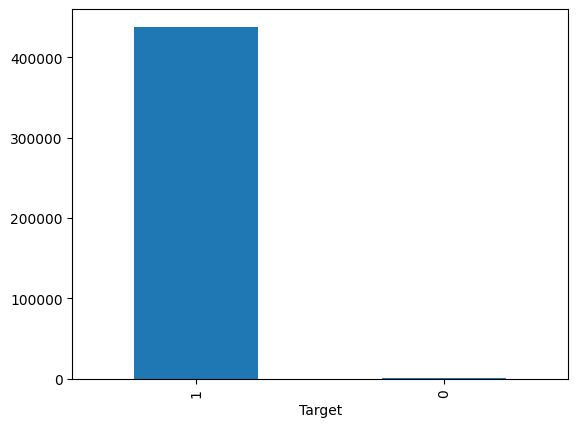

In [16]:
Data["Target"].value_counts().plot(kind = 'bar')
#On remarque clairement un déséquilibre de classe

## Learning curve :
Notre dataset a une distribution extrême du coup mieux d'utiliser en scoring ROC_AUC.
\
ROC-AUC mesure la capacité du modèle à séparer les classes indépendamment du seuil de classification.

In [ ]:
train_sizes = [0.1, 0.25, 0.5, 0.75, 1.0]

train_sizes, train_scores, val_scores = learning_curve(
    estimator= XGBClassifier(
        n_estimators = 200,
        max_depth = 3,
        reg_lambda = 3.5, #L2 régularisation
        reg_alpha = 2.5, #L1 régularisation
        min_child_weight =5 #Bon pour déséquilibre 
        ),
    X=X_train,
    y=y_train,
    train_sizes=train_sizes,
    cv=5,
    scoring="roc_auc", #Notre dataset a une distribution extrême du coup mieux vaut utilsier roc_auc
    shuffle=True,
    random_state=42
)

In [18]:
print('Scores d\'Entrainements : \n\n', train_scores)
print('\n', '-' * 70)
print('\nScores de validations:\n\n', val_scores)

Scores d'Entrainements : 

 [[0.84230562 0.80924534 0.87356668 0.80515734 0.88324752]
 [0.90334903 0.90450626 0.86468852 0.87895238 0.90962784]
 [0.92367477 0.9123957  0.90061991 0.8826229  0.90694751]
 [0.90885688 0.91543739 0.89870533 0.90655517 0.91297421]
 [0.8977352  0.88744598 0.88571391 0.89134608 0.90299025]]

 ----------------------------------------------------------------------

Scores de validations:

 [[0.54082997 0.54048572 0.57199771 0.53824226 0.57049664]
 [0.57880664 0.55156336 0.55464775 0.59094226 0.54636387]
 [0.61470102 0.58024903 0.66570702 0.62230432 0.59244295]
 [0.65420671 0.66228186 0.6888201  0.65873938 0.62177067]
 [0.69648661 0.66902148 0.74071674 0.68358389 0.63724809]]


**Diagnostic :**

- Overfitting modéré : l'écart train–val diminue de 0.41 → 0.23 avec plus de données.  
- Performance finale : $\text{ROC-AUC} = 0.72$ (modèle correct, supérieur au hasard = 0.5)

\
Modèle bien régularisé avec un bon équilibre biais–variance.


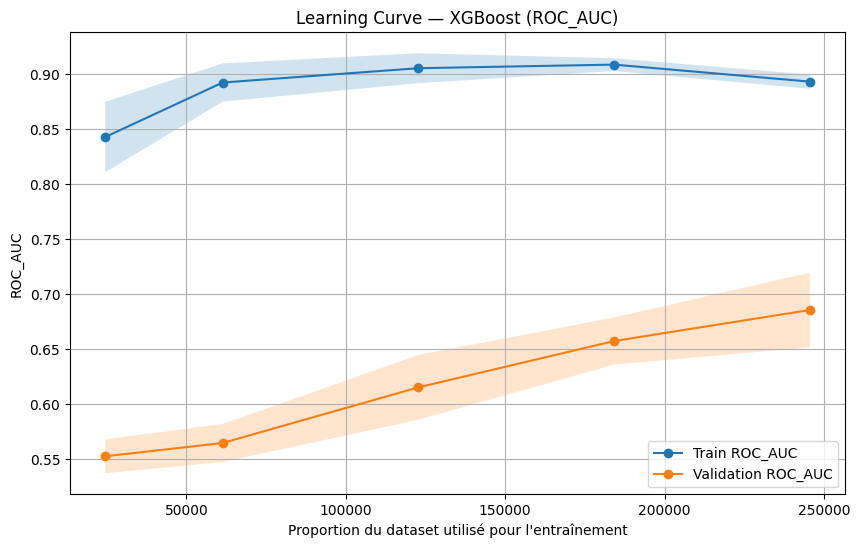

In [19]:
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)

val_mean   = np.mean(val_scores, axis=1)
val_std    = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(10,6))

plt.plot(train_sizes, train_mean, marker='o', label='Train ROC_AUC')
plt.plot(train_sizes, val_mean, marker='o', label='Validation ROC_AUC')

# Zones d'incertitude
plt.fill_between(train_sizes, train_mean - train_std, 
                 train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, 
                 val_mean + val_std, alpha=0.2)

plt.title("Learning Curve — XGBoost (ROC_AUC)")
plt.xlabel("Proportion du dataset utilisé pour l'entraînement")
plt.ylabel("ROC_AUC")
plt.legend()
plt.grid(True)
plt.show()

## Cross Validation and Boostrap

In [ ]:
#Cross Validation
Model = XGBClassifier(
    n_estimators =200,
    max_depth = 3,
    reg_lambda = 3.5,
    reg_alpha = 2.5,
    min_child_weight =5
    )

kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
results = cross_val_score(Model,X_train,y_train, cv = kfold, scoring= "roc_auc")
print("ROC_AUC par Fold:", results)
print("Moyenne des ROC_ AUC: %.3f%%" % (results.mean()*100))
print("L'écart type:", results.std())

ROC_AUC par Fold: [0.69686832 0.7452611  0.75048916 0.59680186 0.7077531  0.70979812
 0.72571047 0.65137902 0.70460594 0.69648818 0.72842751 0.70971429
 0.66651961 0.71374022 0.698938   0.61615123 0.62027281 0.66514875
 0.76211272 0.68266497 0.66720128 0.77731456 0.73054688 0.76147864
 0.64147748 0.72473046 0.65218494 0.67674972 0.69849003 0.67829559
 0.69483544 0.70654301 0.71439383 0.65689765 0.66402166 0.68272084
 0.73506771 0.68128374 0.73538014 0.68835525 0.75284638 0.74050759
 0.76636074 0.58076906 0.73180136 0.63999844 0.64898257 0.69160668
 0.69715319 0.7589512 ]
Moyenne des ROC_ AUC: 69.652%
La variance: 0.04437514324619873


### Analyse de la Variabilité

**Stabilité du modèle :**
L'écart-type de σ = 0.044 indique une **variabilité modérée** des scores. Le modèle présente une performance relativement stable.

**Dépendance aux splits (Q2.2) :**
L'étendue des scores [0.58, 0.78] révèle une **hétérogénéité dans le dataset**. Certains folds obtiennent des performances élevées (AUC ≈ 0.75-0.78) tandis que d'autres sont plus difficiles (AUC ≈ 0.58-0.65). Cette variabilité suggère la présence de **sous-populations distinctes** dans les données, typique des problèmes de crédit réels.

**Décomposition biais-variance :**
$$\text{Erreur} = \underbrace{(1 - 0.697)^2}_{\text{Biais}^2 \approx 0.092} + \underbrace{0.044^2}_{\text{Variance} \approx 0.002} + \sigma^2_{\text{irréductible}}$$

Le modèle souffre davantage d'un **biais modéré** (sous-apprentissage) que de variance excessive, confirmant que la régularisation appliquée (λ=3.5, α=2.5) est appropriée.

**Conclusion :**
Performance stable mais perfectible. La variabilité observée reflète la **complexité intrinsèque** du problème de prédiction du risque de crédit plutôt qu'une instabilité du modèle.

In [ ]:
#Bootstrap
n_iteration = 30
bootstrap_scores = []

for i in range(n_iteration):
    #On crée un échantillon Bootstrap
    X_boot, y_boot = resample(X_train, y_train, random_state=i)

    #On entraine et évalue notre modèle
    Model.fit(X_boot,y_boot)
    score = roc_auc_score(y_test, Model.predict_proba(X_test)[:, 1])
    bootstrap_scores.append(score)

bootstrap_scores = np.array(bootstrap_scores)
print("ROC_AUC par itération Bootstrap", bootstrap_scores)
print("Moyenne des ROC_AUC : %.3f%%" % (bootstrap_scores.mean()*100))
print("L'écart type est :", bootstrap_scores.std())


ROC_AUC par itération Bootstrap [0.6840098  0.68267357 0.66365506 0.65676676 0.67360631 0.67135194
 0.64389472 0.66320228 0.68816868 0.6618721  0.63229936 0.66748513
 0.66252224 0.66172837 0.68013122 0.69647481 0.63151878 0.66399674
 0.66043238 0.6396493  0.66702613 0.63974229 0.65503856 0.68965401
 0.66109894 0.67843446 0.67851091 0.67645702 0.68613721 0.68002126]
Moyenne des ROC_AUC : 66.659%
L'écart type est : 0.016739276511795367


### Comparaison CV vs Bootstrap

| Méthode | Moyenne | Écart-type | Stabilité |
|---------|---------|------------|-----------|
| **CV (k=10, r=5)** | 0.697 | 0.044 | Modérée |
| **Bootstrap (n=30)** | 0.667 | **0.017** | Élevée |

**Observations :**

1. **Différence de performance** : Le bootstrap sous-estime la performance de 3% (0.697 → 0.667). Ceci s'explique par l'échantillonnage avec remplacement qui crée des échantillons moins représentatifs que la CV stratifiée.

2. **Stabilité supérieure du bootstrap** : L'écart-type bootstrap (0.017) est plus faible que celui de la CV (0.044). Le bootstrap lisse les différences entre sous-groupes grâce à l'échantillonnage aléatoire.

3. **Cohérence des conclusions** : Malgré la différence de 3%, les deux méthodes convergent vers un ROC-AUC ≈ 0.67-0.70, confirmant que le modèle discrimine correctement les bons et mauvais clients.

**Conclusion**
 Les conclusions de performance sont **globalement stables** : les deux méthodes confirment un modèle performant (AUC > 0.65) mais perfectible. La CV stratifiée est préférable pour ce problème car elle préserve mieux la distribution déséquilibrée des classes.

## Optimisation des hyperparamètres

In [40]:
from scipy.stats import uniform, randint

#Espace de recherche pour RandomizedSearch
param_distributions = {
    'n_estimators': randint(100,500),
    'max_depth': randint(2,6),
    'learning_rate': uniform(0.01,0.19),
    'reg_lambda' : uniform(0.5,4.5),
    'reg_alpha' : uniform(0.0,3.5),
    'min_child_weight' : randint(1,10)
}

#RandomizedSearch
random_search = RandomizedSearchCV(
    XGBClassifier(random_state = 42),
    param_distributions,
    n_iter= 30,
    cv = StratifiedKFold(n_splits=5, shuffle= True, random_state= 42),
    scoring= "roc_auc",
    n_jobs = -1, #permet d’accélérer la recherche d’hyperparamètres en exploitant tous les cœurs du processeur
    random_state=42,
    verbose = 1 #permet de suivre la progression du RandomizedSearchCV, notamment les itérations en cours
)

random_search.fit(X_train,y_train)
print(f"Le Meilleur Score est : {random_search.best_score_:.4f}")
print(f"\n Les Meilleurs Paramètres sont :")
for parm, value in random_search.best_params_.items():
    print(f"{parm} : {value}")


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Le Meilleur Score est : 0.7298

 Les Meilleurs Paramètres sont :
learning_rate : 0.1975085179540983
max_depth : 5
min_child_weight : 1
n_estimators : 235
reg_alpha : 0.019327409932608397
reg_lambda : 4.169576428046754


Baseline (manuel)    : ROC-AUC = 0.697
\
Après RandomizedSearch : ROC-AUC = 0.7298
\
Amélioration : +0.033 (+3.3%) --> C'est une très bonne amélioration

### Validation Curve

In [ ]:
#Dans notre cas les deux hyperparamètres majeurs pour lesquels on va tester la validation curve sont:
# max_depth ET reg_lambda

from sklearn.model_selection import validation_curve

#On récupére les meilleurs paramètres
best_params = random_search.best_params_

#1er Cas: Pour max_depth
#On fixe tout les paramètres sauf max_depth
param_depth = {k:v for k,v in best_params.items() if k != "max_depth"}
max_depth_range = [2,3,4,5,6]

train_scores_depth, val_scores_depth = validation_curve(
    XGBClassifier(**param_depth, random_state = 42),
    X_train,y_train,
    param_name= "max_depth",
    param_range= max_depth_range,
    cv = StratifiedKFold(n_splits=5, shuffle= True, random_state=42),
    scoring="roc_auc",
    n_jobs=-1
)

#2ème Cas : Pour reg_lambda
# On fixe tout les paramètres sauf reg_lambda
param_lambda = {k:v for k,v in best_params.items() if k != "reg_lambda"}
lambda_range = [0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0]

train_scores_lambda, val_scores_lambda = validation_curve(
    XGBClassifier(**param_lambda, random_state =42),
    X_train,y_train,
    param_name="reg_lambda",
    param_range= lambda_range,
    cv = StratifiedKFold(n_splits=5, shuffle= True, random_state=42),
    scoring="roc_auc",
    n_jobs=-1
)



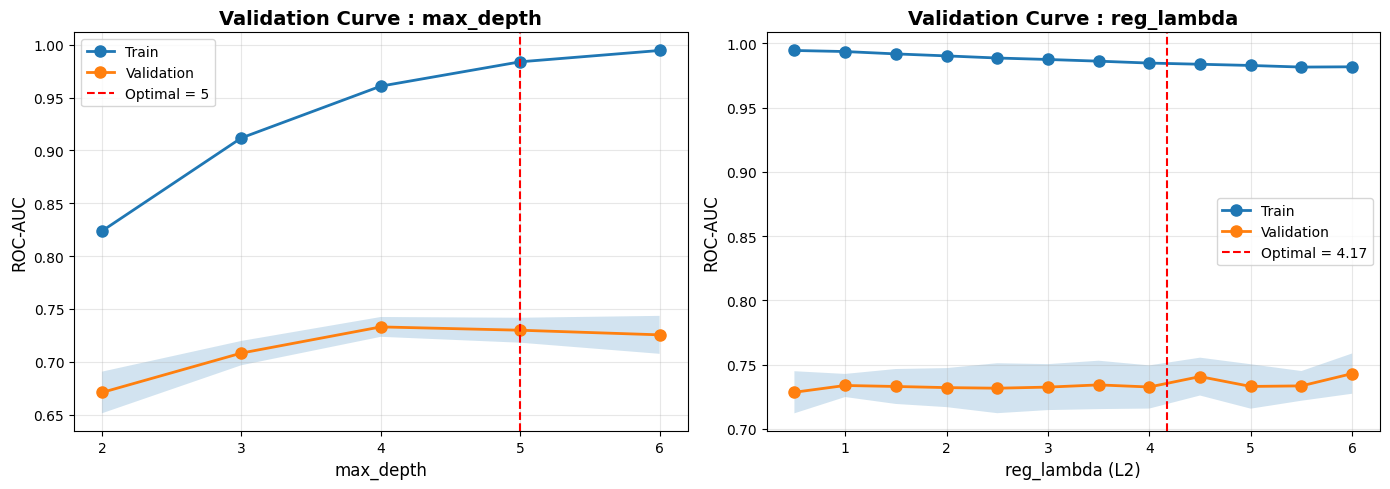

In [ ]:
# GRAPHIQUES
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# max_depth
train_mean_depth = train_scores_depth.mean(axis=1)
val_mean_depth = val_scores_depth.mean(axis=1)
train_std_depth = train_scores_depth.std(axis=1)
val_std_depth = val_scores_depth.std(axis=1)

axes[0].plot(max_depth_range, train_mean_depth, 'o-', label='Train', linewidth=2, markersize=8)
axes[0].plot(max_depth_range, val_mean_depth, 'o-', label='Validation', linewidth=2, markersize=8)
axes[0].fill_between(max_depth_range, val_mean_depth - val_std_depth, val_mean_depth + val_std_depth, alpha=0.2)
axes[0].axvline(best_params['max_depth'], color='red', linestyle='--', label=f"Optimal = {best_params['max_depth']}")
axes[0].set_xlabel('max_depth', fontsize=12)
axes[0].set_ylabel('ROC-AUC', fontsize=12)
axes[0].set_title('Validation Curve : max_depth', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].set_xticks(max_depth_range)

# reg_lambda
train_mean_lambda = train_scores_lambda.mean(axis=1)
val_mean_lambda = val_scores_lambda.mean(axis=1)
train_std_lambda = train_scores_lambda.std(axis=1)
val_std_lambda = val_scores_lambda.std(axis=1)

axes[1].plot(lambda_range, train_mean_lambda, 'o-', label='Train', linewidth=2, markersize=8)
axes[1].plot(lambda_range, val_mean_lambda, 'o-', label='Validation', linewidth=2, markersize=8)
axes[1].fill_between(lambda_range, val_mean_lambda - val_std_lambda, val_mean_lambda + val_std_lambda, alpha=0.2)
axes[1].axvline(best_params['reg_lambda'], color='red', linestyle='--', label=f"Optimal = {best_params['reg_lambda']:.2f}")
axes[1].set_xlabel('reg_lambda (L2)', fontsize=12)
axes[1].set_ylabel('ROC-AUC', fontsize=12)
axes[1].set_title('Validation Curve : reg_lambda', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


### max_depth

**Zone d'underfitting** : max_depth ≤ 3
- Val score < 0.72
- Modèle trop simple

**Zone optimale** : max_depth ∈ [4, 5]
- Val score maximal = 0.73
- Zone stable (variation < 0.01)

**Zone d'overfitting** : max_depth ≥ 6
- Val score diminue (0.72)
- Écart train-val > 0.27
- Train score = 1.00 (mémorisation)

### reg_lambda

**Plateau de performance** : reg_lambda ∈ [1.0, 6.0]
- Val score constant ~0.73-0.74
- Très faible sensibilité aux variations
- Zone extrêmement stable

**Optimal = 4.17** : Au centre de la zone stable

### Conclusion
 Les hyperparamètres trouvés par RandomizedSearch sont **validés** :
- max_depth = 5 → Zone optimale
- reg_lambda = 4.17 → Plateau stable

 Configurations **robustes** :
- max_depth : Tolérance ±1 (4-5 donnent scores similaires)
- reg_lambda : Large tolérance (2.0-6.0 équivalents)

In [49]:
best_model = XGBClassifier(**best_params, random_state = 42) #Le modèle avec les meillleurs paramètres

#Réévaluation sur multiples splits
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
final_score = cross_val_score(
    best_model,X_train,y_train,
    cv= kfold,
    scoring= "roc_auc"
)

print(f"ROC_AUC par Fold: {final_score}")
print("La Moyenne des ROC_AUC est %.3f%%" % (final_score.mean()*100))

ROC_AUC par Fold: [0.72466787 0.75953907 0.80114659 0.67566587 0.73308428 0.77012531
 0.76039047 0.69885534 0.70835888 0.74610405 0.71262269 0.7550382
 0.7267622  0.69027729 0.77054865 0.68895036 0.66783496 0.69481524
 0.78923603 0.71160158 0.71419126 0.8197536  0.74358441 0.76435479
 0.69765887 0.72032708 0.68556998 0.71364174 0.72568503 0.76438694]
La Moyenne des ROC_AUC est 73.116%


## Interprétabilité (SHAP et Permutation)


In [50]:
# Modèle final avec les meilleurs hyperparamètres
best_model = XGBClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.1975085179540983), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=235, n_jobs=None,
              num_parallel_tree=None, ...)

In [54]:
from sklearn.inspection import permutation_importance

results_permutation = permutation_importance(
    estimator= best_model,
    X= X_test,
    y=y_test,
    n_repeats=30,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42
)

permutation_df =(pd.DataFrame(
    {"features":X_test.columns,
     "importance_mean" : results_permutation.importances_mean,
     "importance_std": results_permutation.importances_std}
).sort_values("importance_mean",ascending= False)
)

permutation_df.head(10)


,features,importance_mean,importance_std
9,DAYS_BIRTH,0.080717,0.012137
10,DAYS_EMPLOYED,0.051647,0.012170
5,NAME_INCOME_TYPE,0.034508,0.008283
4,AMT_INCOME_TOTAL,0.028201,0.008673
15,CNT_FAM_MEMBERS,0.027395,0.004628
7,NAME_FAMILY_STATUS,0.026237,0.007244
3,CNT_CHILDREN,0.009140,0.002868
2,FLAG_OWN_REALTY,0.008237,0.003705
13,FLAG_PHONE,0.004931,0.003235
0,CODE_GENDER,0.004451,0.002649


Les features les plus importantes selon la permutation importance sont l’âge du client, la stabilité professionnelle et les variables de revenu. À elles seules, elles expliquent la majeure partie du pouvoir prédictif du modèle. Les variables démographiques familiales ont un impact secondaire mais non négligeable, tandis que les indicateurs simples comme le genre, le nombre d’enfants ou la possession d’un bien immobilier (absurde un peu à première vu mais totalement logique puisque posséder un bien n’est pas un bon indicateur direct de solvabilité + elle ne dit rien sur la valeur du bien ni si c'est hypothéqué etc...) ont une contribution beaucoup plus faible

In [57]:
import shap

# Charger le JS pour les graphiques interactifs
shap.initjs()
# Explainer basé sur le modèle final
explainer = shap.TreeExplainer(best_model)
#Calculer les valeurs SHAP sur X_test
shap_values = explainer.shap_values(X_test)

shap_importance_df = (
    pd.DataFrame({
        "feature": X_test.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0)
    })
    .sort_values("mean_abs_shap", ascending=False)
)

shap_importance_df.head(10)

,feature,mean_abs_shap
9,DAYS_BIRTH,0.538185
10,DAYS_EMPLOYED,0.472457
4,AMT_INCOME_TOTAL,0.354866
7,NAME_FAMILY_STATUS,0.312934
5,NAME_INCOME_TYPE,0.206797
15,CNT_FAM_MEMBERS,0.190466
2,FLAG_OWN_REALTY,0.173640
0,CODE_GENDER,0.134512
3,CNT_CHILDREN,0.121689
6,NAME_EDUCATION_TYPE,0.114941


Les valeurs SHAP globales confirment que les variables les plus déterminantes pour le modèle sont :

- **DAYS_BIRTH** (0.538) : l’âge influence fortement la probabilité prédite. Les individus plus jeunes ou appartenant à certaines tranches d’âge apparaissent plus risqués.
- **DAYS_EMPLOYED** (0.472) : la stabilité professionnelle joue un rôle majeur dans la prédiction du risque.
- **AMT_INCOME_TOTAL** (0.355) : le revenu total est un facteur discriminant important.
- **NAME_FAMILY_STATUS** (0.313) : la situation familiale exerce une influence notable (célibataire, marié, divorcé…).
- **NAME_INCOME_TYPE** (0.207) et **CNT_FAM_MEMBERS** (0.190) : le type de revenu et la structure familiale ont un impact modéré mais significatif.
- **FLAG_OWN_REALTY** (0.174) : la possession d’un bien immobilier contribue au score mais reste moins déterminante que les variables économiques.
- Les autres variables (**CODE_GENDER**, **CNT_CHILDREN**, **NAME_EDUCATION_TYPE**) ont un impact plus faible mais demeurent non négligeables.

SHAP montre clairement que le modèle s’appuie avant tout sur des facteurs socio-économiques structurants (âge, stabilité professionnelle, revenu).


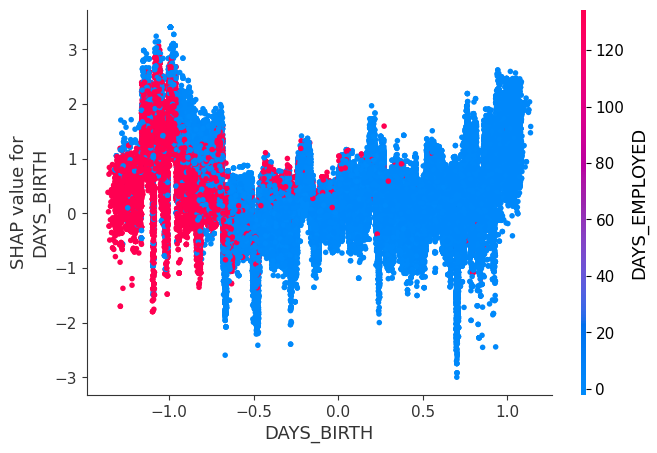

In [58]:
shap.dependence_plot("DAYS_BIRTH", shap_values, X_test)

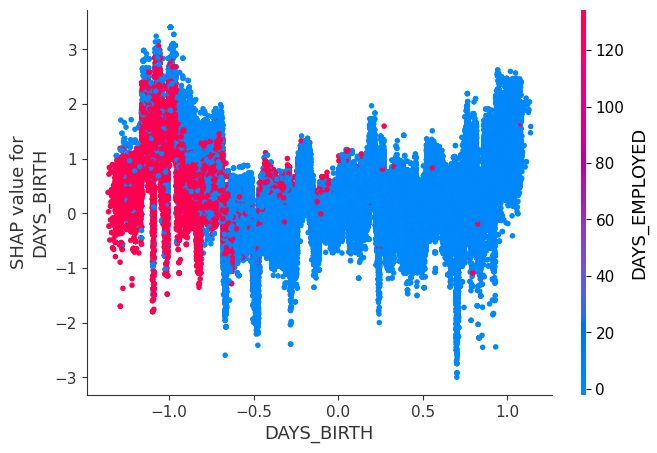

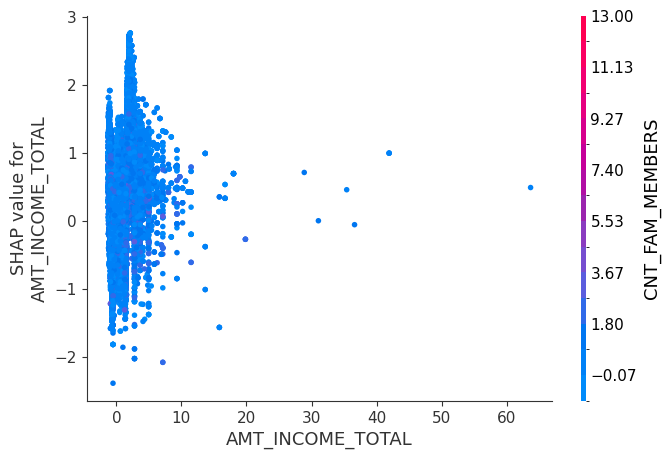

In [59]:
# Dépendance partielle SHAP pour DAYS_BIRTH
shap.dependence_plot(
    "DAYS_BIRTH",
    shap_values,
    X_test,
    interaction_index="DAYS_EMPLOYED"  # interaction affichée en couleur
)

# Dépendance partielle SHAP pour AMT_INCOME_TOTAL
shap.dependence_plot(
    "AMT_INCOME_TOTAL",
    shap_values,
    X_test,
    interaction_index="CNT_FAM_MEMBERS"
)

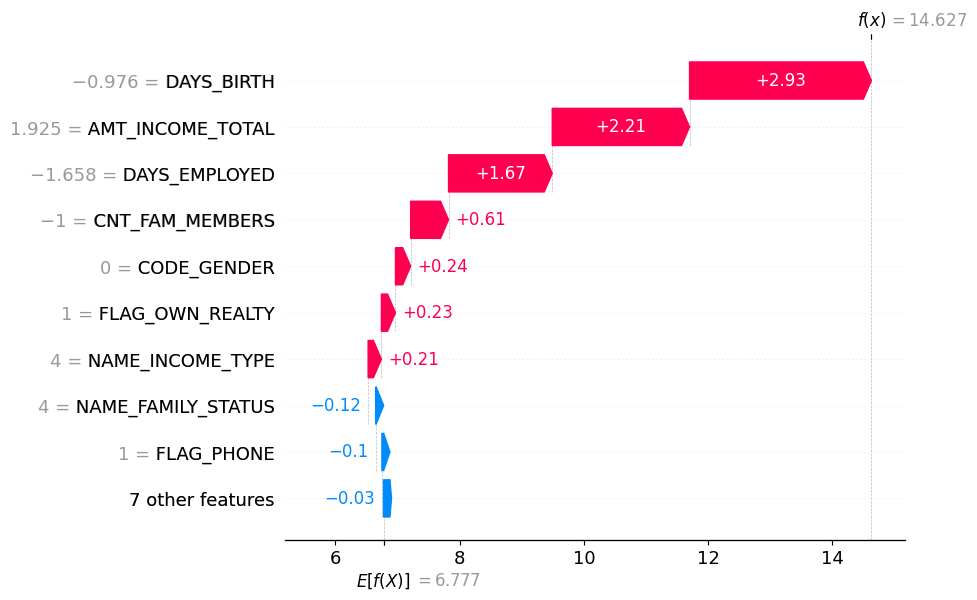

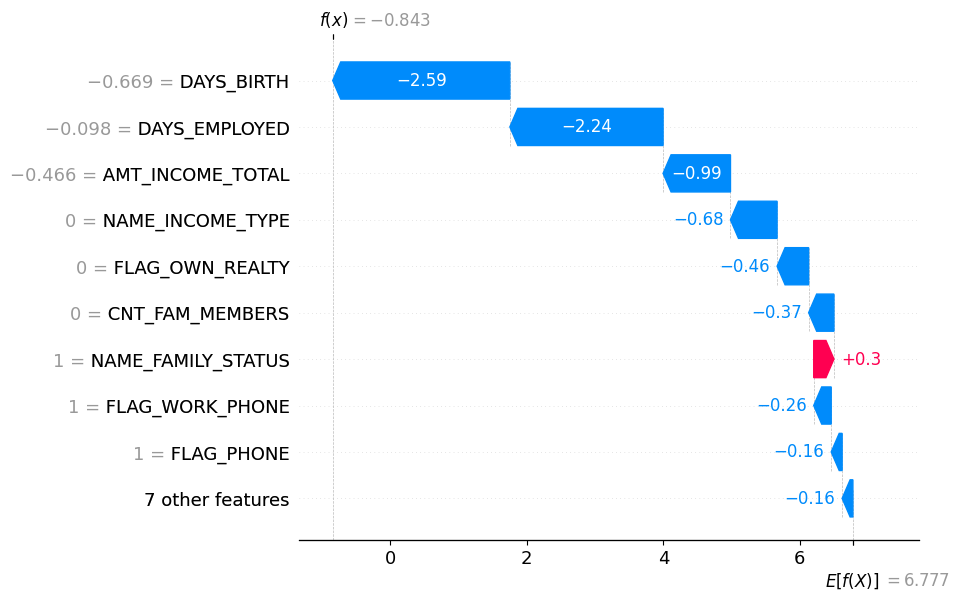

In [63]:
import numpy as np

# Probabilités de défaut sur le test
y_proba_test = best_model.predict_proba(X_test)[:, 1]

# Observation la plus risquée (proba max)
idx_risky = np.argmax(y_proba_test)

# Observation la moins risquée (proba min)
idx_safe = np.argmin(y_proba_test)

# Explication locale pour l'individu risqué
x_risky = X_test.iloc[idx_risky]
shap_risky = shap_values[idx_risky]

shap.waterfall_plot(
    shap.Explanation(
        values=shap_risky,
        base_values=explainer.expected_value,
        data=x_risky,
        feature_names=X_test.columns
    )
)

# Explication locale pour l'individu peu risqué
x_safe = X_test.iloc[idx_safe]
shap_safe = shap_values[idx_safe]

shap.waterfall_plot(
    shap.Explanation(
        values=shap_safe,
        base_values=explainer.expected_value,
        data=x_safe,
        feature_names=X_test.columns
    )
)


Le premier individu présente une probabilité de défaut élevée. Le waterfall plot SHAP montre que plusieurs variables tirent fortement la prédiction vers le haut.

Les principales contributions positives sont :
- **AMT_INCOME_TOTAL (+2.93)** : bien que contre-intuitif, cette valeur indique ici un revenu incohérent avec d’autres caractéristiques (ex. faible stabilité professionnelle). Cela crée un profil atypique que le modèle associe à un risque élevé.
- **DAYS_EMPLOYED (+1.67)** : l’individu a une très faible ancienneté professionnelle (valeur négative, faible durée). C’est un facteur de risque majeur selon SHAP.
- **CNT_FAM_MEMBERS (+0.61)** : un nombre élevé de membres dans le foyer augmente la charge financière.
- **CODE_GENDER (+0.24)** et **FLAG_OWN_REALTY (+0.23)** : certains groupes démographiques et patrimoniaux sont sur-représentés dans les catégories risquées du dataset.
- **NAME_INCOME_TYPE (+0.21)** : ce type de revenu correspond statistiquement à une faible stabilité (ex. travail informel / indépendant).

Quelques variables ont un léger effet protecteur (ex. `NAME_FAMILY_STATUS` et `FLAG_PHONE`), mais leur contribution reste marginale.

**Conclusion :**  
La combinaison “faible stabilité d’emploi + charge familiale + revenu atypique + caractéristiques socio-démographiques défavorables” explique parfaitement la forte probabilité de défaut.  
L’interprétation locale est **cohérente avec l’intuition métier**.


Le deuxième individu présente une probabilité de défaut très faible. Le waterfall plot SHAP est dominé par des contributions négatives, indiquant un profil particulièrement stable.

Les principales contributions qui réduisent le risque sont :
- **DAYS_BIRTH (–2.59)** : l’individu est nettement plus âgé que la moyenne du dataset. L’âge étant fortement corrélé à la stabilité, cette variable diminue fortement la prédiction.
- **DAYS_EMPLOYED (–2.24)** : une grande ancienneté professionnelle réduit massivement le risque.
- **AMT_INCOME_TOTAL (–0.99)** : l’individu dispose d’un revenu élevé ou régulier, diminuant naturellement la probabilité de défaut.
- **NAME_INCOME_TYPE (–0.68)** : type de revenu associé à une forte stabilité (ex. salarié stable).
- **FLAG_OWN_REALTY (–0.46)** : la possession d’un bien immobilier est ici interprétée comme un signe de stabilité financière.

Les variables démographiques (genre, famille, enfants) réduisent également légèrement le risque.

**Conclusion :**  
Ce client coche toutes les cases d’un profil sûr : stable professionnellement, revenu élevé, âge avancé, situation patrimoniale favorable.  
L’explication locale est **totalement cohérente avec les règles métier d’un score de crédit.**
